In [1]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)


Required libraries imported successfully!


In [ ]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

In [3]:
def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    out_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            id = data['_id']
            del data['_id']
            out_dict[id] = data 
    return out_dict
   
def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    out_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            id = data['_id']
            del data['_id']
            out_dict[id] = data 
    return out_dict

def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    """    
    Load relevance judgments from TSV file.
    Returns dictionary mapping query IDs to candidate relevance scores.
    """
    data = pd.read_csv(file_path, sep = '\t')
    out = {
    query_id: {r['corpus-id']: r['score'] for _, r in grp.iterrows()}
    for query_id, grp in data.groupby('query-id')
    }
    return out
    

In [4]:
file_path_corpus = "dataset_BE2/corpus.jsonl"
corpus = load_corpus(file_path_corpus)

file_path_query = "dataset_BE2/queries.jsonl"
queries = load_queries(file_path_query)

file_path_qrels = "dataset_BE2/valid.tsv"
qrels = load_qrels(file_path_qrels)

In [5]:
titles = []
for key, dic in corpus.items():
    title = dic['title']
    titles.append(title)

In [6]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(titles)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [7]:
titles_matrix = count_vectorizer.transform(titles)

In [8]:
titles_matrix.shape

(25657, 20075)

In [14]:
count_vectorizer.vocabulary_

{'hybrid': 8630,
 'of': 12584,
 'genetic': 7657,
 'algorithm': 948,
 'and': 1149,
 'particle': 13193,
 'swarm': 17668,
 'optimization': 12764,
 'for': 7259,
 'recurrent': 15022,
 'network': 12138,
 'design': 5077,
 'ep': 6303,
 'sqp': 17031,
 'dynamic': 5750,
 'economic': 5852,
 'dispatch': 5401,
 'with': 19810,
 'nonsmooth': 12374,
 'fuel': 7464,
 'cost': 4266,
 'function': 7473,
 'fuzzy': 7506,
 'systems': 17771,
 'evolutionary': 6513,
 'tuning': 18718,
 'learning': 10101,
 'knowledge': 9865,
 'bases': 1981,
 'modified': 11480,
 'optimizer': 12768,
 'identification': 8770,
 'control': 4113,
 'using': 19116,
 'neural': 12144,
 'networks': 12141,
 'separate': 16211,
 'face': 6749,
 'body': 2429,
 'selectivity': 16131,
 'on': 12648,
 'the': 18107,
 'fusiform': 7496,
 'gyrus': 8062,
 'scheduling': 15917,
 'reduced': 15041,
 'cpu': 4327,
 'energy': 6211,
 'data': 4675,
 'mining': 11343,
 'approach': 1352,
 'location': 10384,
 'prediction': 14075,
 'in': 8947,
 'mobile': 11441,
 'environme

In [22]:
print_feats(titles_matrix, count_vectorizer.get_feature_names_out())

,word,value
0,action,11
1,graph,9
2,embedding,8
3,layer,5
4,the,5
5,the,4
6,of,4
7,service,4
8,pose,4
9,customer,4


(array([1.968e+04, 2.410e+02, 5.400e+01, 4.400e+01, 1.100e+01, 8.000e+00,
        6.000e+00, 5.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

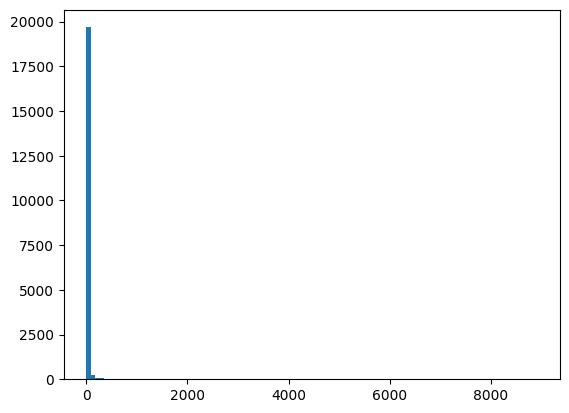

In [34]:
plt.hist(titles_matrix.sum(axis=0).tolist()[0], bins = 100)